
Processing for y(0) = 0
  Forward integration for y0=0 stopped at t=1.646523, y=1.74e+06. Status: -1. Message: Required step size is less than spacing between numbers.
  Extrapolated forward asymptote b for y0=0: 1.646523
  Backward integration for y0=0 reached -t_span_limit=-20 without apparent blow-up. y_final=2.00e+01
  For y(0) = 0, estimated domain: (-inf, 1.646523)

Processing for y(0) = 1
  Forward integration for y0=1 stopped at t=0.498290, y=3.49e+06. Status: -1. Message: Required step size is less than spacing between numbers.
  Extrapolated forward asymptote b for y0=1: 0.498290
  Backward integration for y0=1 reached -t_span_limit=-20 without apparent blow-up. y_final=2.00e+01
  For y(0) = 1, estimated domain: (-inf, 0.498290)

Processing for y(0) = -1
  Forward integration for y0=-1 stopped at t=0.501754, y=-2.47e+06. Status: -1. Message: Required step size is less than spacing between numbers.
  Extrapolated forward asymptote b for y0=-1: 0.501754
  Backward integration 

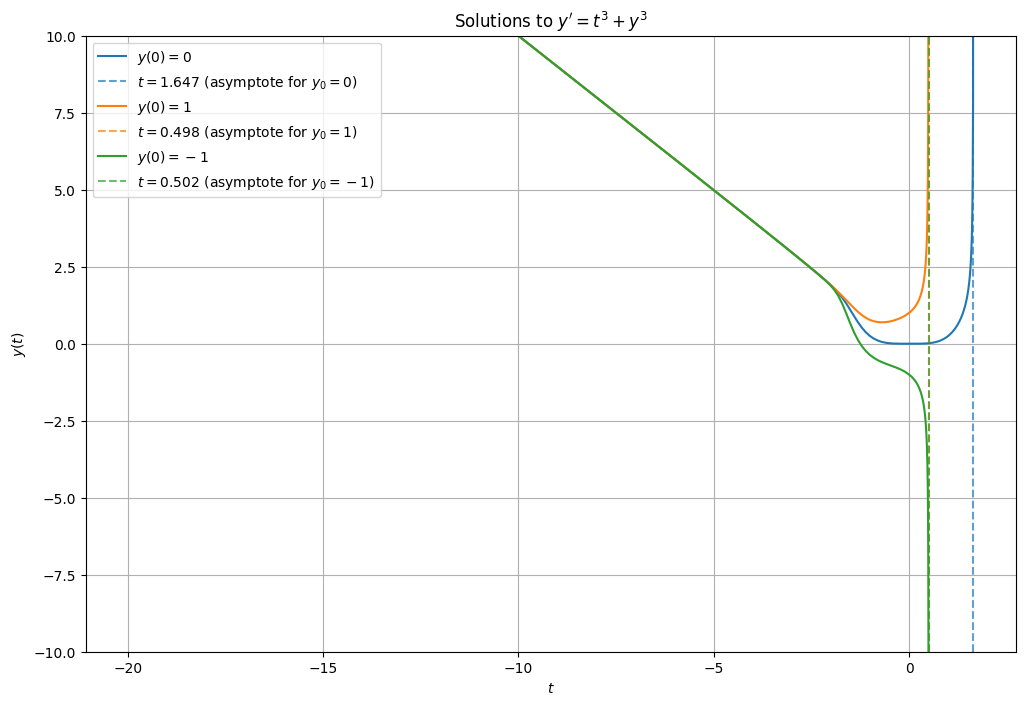


Summary of Maximal Solution Domains:
For y(0) = 0: Domain = (-inf, 1.646523)
For y(0) = 1: Domain = (-inf, 0.498290)
For y(0) = -1: Domain = (-inf, 0.501754)


In [1]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

def ode_func(t, y):
    return t**3 + y**3

# Initial conditions
y0_values = [0, 1, -1]

# Store results: {'y0': {'sol_fwd': sol_fwd, 'sol_bwd': sol_bwd, 'a': a, 'b': b}}
results = {}

# Integration parameters
t_span_limit = 20  # Max integration time in each direction (can be adjusted)
rtol = 1e-9        # Relative tolerance
atol = 1e-12       # Absolute tolerance (important for reaching asymptotes accurately)
# Using a large value for y to stop integration is an option,
# but solve_ivp often handles blow-up by itself by reducing step size until failure.
# We can check sol.status and sol.message.




for y0_val in y0_values:
    print(f"\nProcessing for y(0) = {y0_val}")


    # Forward integration
    # Integrate from t=0 to t_span_limit
    # If it blows up, sol_fwd.t[-1] is an estimate of b
    # We need to make sure t_span is large enough to pass the asymptote if one exists.
    # solve_ivp will stop if it can't proceed (e.g. asymptote)
    sol_fwd = solve_ivp(ode_func, [0, t_span_limit], [y0_val],
                        dense_output=True, rtol=rtol, atol=atol, method='Radau') # Radau is good for stiff problems

    b_asymptote = np.inf
    if sol_fwd.status == 0 and sol_fwd.t[-1] < t_span_limit : # solver might have stopped before t_span_limit due to reaching max_step or other reasons not blowup
         print(f"  Forward integration for y0={y0_val} finished early at t={sol_fwd.t[-1]} but status is 0, message: {sol_fwd.message}. This might indicate it did not blow up or needs longer t_span.")
         # If it truly didn't blow up, b is inf. Otherwise, it might be an issue with solver params or t_span_limit.
         # For this problem, blow-up is expected if y gets large.
         if abs(sol_fwd.y[0,-1]) < 1e6: # Arbitrary threshold to decide if it's not a blow up
            b_asymptote = np.inf
         else: # Assume it was on its way to blow up but stopped.
             t_last_fwd = sol_fwd.t[-1]
             y_last_fwd = sol_fwd.y[0, -1]
             if abs(y_last_fwd) > 1e3 : # Check if y is large enough for extrapolation
                 b_asymptote = t_last_fwd + 1.0 / (2.0 * y_last_fwd**2) if y_last_fwd !=0 else t_last_fwd # to avoid division by zero
                 print(f"  Extrapolated forward asymptote b for y0={y0_val}: {b_asymptote:.6f} from t_last={t_last_fwd:.6f}, y_last={y_last_fwd:.2e}")
             else:
                 print(f"  Forward solution for y0={y0_val} ended at t={t_last_fwd:.6f}, y={y_last_fwd:.2e}, y not large enough for robust extrapolation.")
                 b_asymptote = t_last_fwd # Best guess is where it stopped.
    elif sol_fwd.t[-1] < t_span_limit:  # Solver stopped early, likely due to stiffness/blow-up (status != 0)


        t_last_fwd = sol_fwd.t[-1]
        y_last_fwd = sol_fwd.y[0, -1]
        # Extrapolation for right asymptote b: b_approx = t_last + 1/(2*y_last^2)
        # This formula is for y' ~ y^3.
        # Need to be careful if y_last is small or zero.
        if abs(y_last_fwd) > 1e3: # Check if y is large enough for extrapolation
            b_asymptote = t_last_fwd + 1.0 / (2.0 * y_last_fwd**2)
            print(f"  Forward integration for y0={y0_val} stopped at t={t_last_fwd:.6f}, y={y_last_fwd:.2e}. Status: {sol_fwd.status}. Message: {sol_fwd.message}")
            print(f"  Extrapolated forward asymptote b for y0={y0_val}: {b_asymptote:.6f}")
        else:
            print(f"  Forward integration for y0={y0_val} stopped at t={t_last_fwd:.6f}, y={y_last_fwd:.2e}, y not large enough for robust extrapolation. Status: {sol_fwd.status}. Message: {sol_fwd.message}")
            b_asymptote = t_last_fwd # Best guess is where it stopped.
    else: # Reached t_span_limit
        print(f"  Forward integration for y0={y0_val} reached t_span_limit={t_span_limit} without apparent blow-up. y_final={sol_fwd.y[0,-1]:.2e}")
        b_asymptote = np.inf






    # Backward integration
    # Integrate from t=0 to -t_span_limit
    sol_bwd = solve_ivp(ode_func, [0, -t_span_limit], [y0_val],
                        dense_output=True, rtol=rtol, atol=atol, method='Radau')

    a_asymptote = -np.inf
    if sol_bwd.status == 0 and sol_bwd.t[-1] > -t_span_limit:
        print(f"  Backward integration for y0={y0_val} finished early at t={sol_bwd.t[-1]} but status is 0, message: {sol_bwd.message}. This might indicate it did not blow up or needs longer t_span.")
        if abs(sol_bwd.y[0,-1]) < 1e6:
             a_asymptote = -np.inf
        else:
            t_last_bwd = sol_bwd.t[-1]
            y_last_bwd = sol_bwd.y[0, -1]
            if abs(y_last_bwd) > 1e3:
                a_asymptote = t_last_bwd - 1.0 / (2.0 * y_last_bwd**2) if y_last_bwd != 0 else t_last_bwd
                print(f"  Extrapolated backward asymptote a for y0={y0_val}: {a_asymptote:.6f} from t_last={t_last_bwd:.6f}, y_last={y_last_bwd:.2e}")
            else:
                print(f"  Backward solution for y0={y0_val} ended at t={t_last_bwd:.6f}, y={y_last_bwd:.2e}, y not large enough for robust extrapolation.")
                a_asymptote = t_last_bwd
    elif sol_bwd.t[-1] > -t_span_limit:  # Solver stopped early
        t_last_bwd = sol_bwd.t[-1]
        y_last_bwd = sol_bwd.y[0, -1]
        # Extrapolation for left asymptote a: a_approx = t_last - 1/(2*y_last^2)
        if abs(y_last_bwd) > 1e3:
            a_asymptote = t_last_bwd - 1.0 / (2.0 * y_last_bwd**2)
            print(f"  Backward integration for y0={y0_val} stopped at t={t_last_bwd:.6f}, y={y_last_bwd:.2e}. Status: {sol_bwd.status}. Message: {sol_bwd.message}")
            print(f"  Extrapolated backward asymptote a for y0={y0_val}: {a_asymptote:.6f}")
        else:
            print(f"  Backward integration for y0={y0_val} stopped at t={t_last_bwd:.6f}, y={y_last_bwd:.2e}, y not large enough for robust extrapolation. Status: {sol_bwd.status}. Message: {sol_bwd.message}")
            a_asymptote = t_last_bwd
    else: # Reached -t_span_limit
        print(f"  Backward integration for y0={y0_val} reached -t_span_limit={-t_span_limit} without apparent blow-up. y_final={sol_bwd.y[0,-1]:.2e}")
        a_asymptote = -np.inf

    results[y0_val] = {
        'sol_fwd': sol_fwd,
        'sol_bwd': sol_bwd,
        'a': a_asymptote,
        'b': b_asymptote,
        'domain': (a_asymptote, b_asymptote)
    }

    print(f"  For y(0) = {y0_val}, estimated domain: ({a_asymptote:.6f}, {b_asymptote:.6f})")

# Plotting the solutions
plt.figure(figsize=(12, 8))
for y0_val, res in results.items():
    sol_fwd = res['sol_fwd']
    sol_bwd = res['sol_bwd']
    a = res['a']
    b = res['b']

    # Forward solution plot
    t_plot_fwd = np.linspace(0, sol_fwd.t[-1], 200) # ensure plotting up to where solver stopped
    if b != np.inf and b < sol_fwd.t[-1] + 1/(2*sol_fwd.y[0,-1]**2+1e-9): # A bit of a hack to ensure linspace is valid
        # if extrapolated b is very close to sol_fwd.t[-1] or slightly less due to numerical precision in extrapolation.
        # ensure t_plot_fwd doesn't exceed b by much if b is the true limit
        t_plot_fwd = np.linspace(0, min(sol_fwd.t[-1], b if b >0 else sol_fwd.t[-1] ), 200)


    y_plot_fwd = sol_fwd.sol(t_plot_fwd)[0]

    # Backward solution plot
    t_plot_bwd = np.linspace(sol_bwd.t[-1], 0, 200) # ensure plotting up to where solver stopped
    if a != -np.inf and a > sol_bwd.t[-1] - 1/(2*sol_bwd.y[0,-1]**2+1e-9) :
         t_plot_bwd = np.linspace(max(sol_bwd.t[-1], a if a < 0 else sol_bwd.t[-1]), 0, 200)


    y_plot_bwd = sol_bwd.sol(t_plot_bwd)[0]

    # Combine and remove duplicates, sort by time
    t_combined = np.concatenate((t_plot_bwd[:-1], t_plot_fwd)) # Avoid duplicating t=0
    y_combined = np.concatenate((y_plot_bwd[:-1], y_plot_fwd))

    # Sort by t for correct plotting
    sort_indices = np.argsort(t_combined)
    t_combined = t_combined[sort_indices]
    y_combined = y_combined[sort_indices]
    
    # Filter out extreme values if they mess up the plot too much before reaching asymptote line
    # y_combined = np.clip(y_combined, -50, 50) # Optional: for better visualization if blowup is too fast

    plt.plot(t_combined, y_combined, label=f'$y(0) = {y0_val}$')

    if b != np.inf:
        plt.axvline(x=b, linestyle='--', color=plt.gca().lines[-1].get_color(), alpha=0.7, label=f'$t={b:.3f}$ (asymptote for $y_0={y0_val}$)')
    if a != -np.inf:
        plt.axvline(x=a, linestyle='--', color=plt.gca().lines[-1].get_color(), alpha=0.7, label=f'$t={a:.3f}$ (asymptote for $y_0={y0_val}$)')


plt.xlabel('$t$')
plt.ylabel('$y(t)$')
plt.title('Solutions to $y\' = t^3 + y^3$')
plt.legend(loc='best')
plt.grid(True)
plt.ylim([-10, 10]) # Adjust ylim for better visualization of behavior near origin; asymptotes make it hard to see all details.
plt.show()

# Print summary of domains
print("\nSummary of Maximal Solution Domains:")
for y0_val, res in results.items():
    print(f"For y(0) = {y0_val}: Domain = ({res['domain'][0]:.6f}, {res['domain'][1]:.6f})")